## Part 2: Exploratory Data Analysis

Let's continue with Store_312 for now.

We'll use this part of the project to answer our secondary objetives:
 1. Which month has the highest average sales in dollars for each store?
 2. Which SKU is the most popular in each store?
 3. Are the sales (in units) between the different SKUs from China Imports correlated for each store?
 4. TinyCo is thinking of running a one day promo on each week – which day of the week makes the most sense for each store?
 5. How do Unit Sales change over time?
 6. Are the sales across all stores correlated?

Let us answer all these questions, one at a time.

First, we import the necessary modules and our data.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

In [2]:
SKU_Master = pd.read_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/SKU_Master_clean.csv", index_col=0)
Store_312 = pd.read_csv("/Users/mac/Desktop/Data Science/Projects/TinyCo Project/Store_312_clean.csv", index_col=0)

Let's inspect our datasets to make sure everything went well.

In [3]:
Store_312.head()

,SKU,Date,Unit Sales,Dollar Sales
0,50012011250,2014-08-04,3,29.97
1,50012011250,2014-08-05,2,19.98
2,50012011250,2014-08-06,5,49.95
3,50012011250,2014-08-07,3,29.97
4,50012011250,2014-08-08,7,69.93


In [4]:
print("The Store_312 dataset has {} rows and {} columns\n".format(Store_312.shape[0], Store_312.shape[1]))
Store_312.dtypes

The Store_312 dataset has 3565 rows and 4 columns



SKU               int64
Date             object
Unit Sales        int64
Dollar Sales    float64
dtype: object

In [5]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales
4,5001,201,12,4,50012011240,2.5,7.99,China Imports
5,5001,201,12,5,50012011250,7.5,9.99,China Imports
6,5001,201,13,4,50012011341,2.5,4.99,China Imports
7,5001,300,1,1,50013000110,6.5,12.99,China Imports
8,5001,201,13,4,50012011340,2.5,4.99,China Imports


In [6]:
print("The SKU_Master dataset has {} rows and {} columns\n".format(SKU_Master.shape[0], SKU_Master.shape[1]))
SKU_Master.dtypes

The SKU_Master dataset has 9 rows and 8 columns



Department      int64
Class           int64
Style           int64
Color           int64
SKU             int64
Cost          float64
Price         float64
Vendor         object
dtype: object

Our data seems to be in the state we left it in in the last notebook.

#### Creating a Date Index

In [7]:
Store_312.head()

,SKU,Date,Unit Sales,Dollar Sales
0,50012011250,2014-08-04,3,29.97
1,50012011250,2014-08-05,2,19.98
2,50012011250,2014-08-06,5,49.95
3,50012011250,2014-08-07,3,29.97
4,50012011250,2014-08-08,7,69.93


At the moment, our dataset uses a normal numerical index to identify its rows. Most of the questions we're going to be answering in this project are time sensitive, so we are going to need to identify sales by date. One way to efficiently do this is to index the entire dataset by date. Luckily, we already have a date column. It has a dtype of object/string, so first we have to convert it to datetime.

In [8]:
Store_312["Date"] = pd.to_datetime(Store_312["Date"])
Store_312.dtypes

SKU                      int64
Date            datetime64[ns]
Unit Sales               int64
Dollar Sales           float64
dtype: object

Our "Date" values are now of type datetime. Next, we should make the "Date" column our index.

In [9]:
Store_312.set_index("Date", inplace=True)
Store_312.head()

,SKU,Unit Sales,Dollar Sales
Date,,,
2014-08-04,50012011250,3,29.97
2014-08-05,50012011250,2,19.98
2014-08-06,50012011250,5,49.95
2014-08-07,50012011250,3,29.97
2014-08-08,50012011250,7,69.93


### 1. Which month has the highest average sales in dollars for Store 312?

To answer our question, we need to create a month column.

In [10]:
Store_312["Month"] = Store_312.index.strftime("%b")

In [11]:
Store_312.head()

,SKU,Unit Sales,Dollar Sales,Month
Date,,,,
2014-08-04,50012011250,3,29.97,Aug
2014-08-05,50012011250,2,19.98,Aug
2014-08-06,50012011250,5,49.95,Aug
2014-08-07,50012011250,3,29.97,Aug
2014-08-08,50012011250,7,69.93,Aug


We now have a column that shows month.

Now let's pivot our table on "Dollar Sales", averaging out values on "Month".

In [12]:
Month_avg = Store_312.pivot_table(values="Dollar Sales", index="Month", aggfunc="mean").sort_values("Dollar Sales", ascending=False)

       Dollar Sales
Month              
May      102.990188


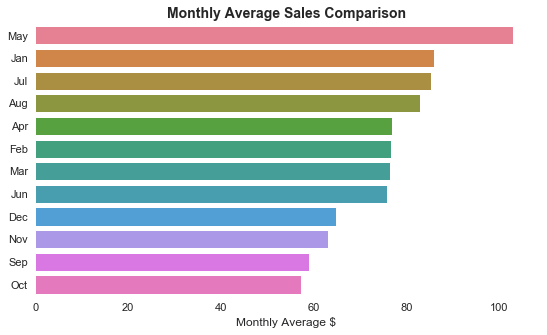

In [13]:
print(Month_avg.head(1))

sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(9,5))
ax = sns.barplot(data=Month_avg, x= "Dollar Sales", y = Month_avg.index, orient="h")
ax.set_ylabel("")
ax.set_xlabel("Monthly Average $", fontsize=12)
ax.set_title("Monthly Average Sales Comparison", fontweight="bold", fontsize=14)
ax.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

The bar graph above clearly shows us that May is the most favorable period of the year when it comes to sales. January also comes in second, probably due to annual clearance sales. Surprisingly, the festive months, i.e., Oct - Dec, are the worst performing quarter.

### 2. Which SKU is the most popular in Store 312?

The SKU that is most popular in Store_312 is the one with the most sales. However, let's also compare all SKUs to see how they've all performed over the period in question.

In [14]:
Pop = Store_312.pivot_table(values="Unit Sales", index="SKU", aggfunc="sum").sort_values("Unit Sales", ascending=False)

In [15]:
Pop['Percentage'] = (Pop['Unit Sales']/Pop['Unit Sales'].sum())*100
Pop.head(3)

,Unit Sales,Percentage
SKU,,
8000451112,11398,54.782274
8000520021,2742,13.178891
50012011250,1974,9.487648


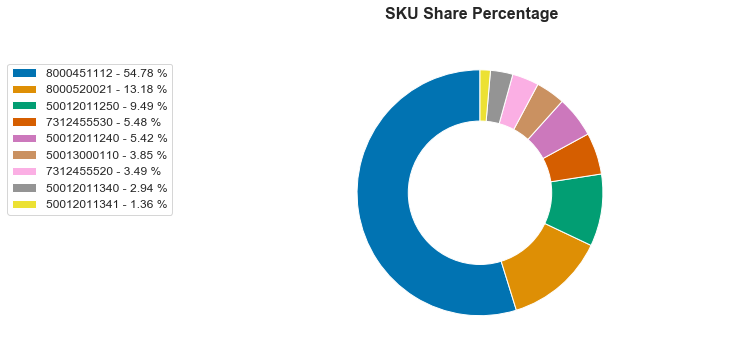

In [16]:
sns.set_palette("colorblind", 12)

fig, ax = plt.subplots(figsize=(9,5))

fig.suptitle("SKU Share Percentage", fontsize=16, fontweight="bold", y=1.02)

patches, texts = plt.pie(Pop.Percentage, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(Pop.index, Pop.Percentage)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, Pop.Percentage),
                                          key=lambda x: x[2],
                                          reverse=True))

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')    
    
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)

plt.show()

In [17]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales
4,5001,201,12,4,50012011240,2.5,7.99,China Imports
5,5001,201,12,5,50012011250,7.5,9.99,China Imports
6,5001,201,13,4,50012011341,2.5,4.99,China Imports
7,5001,300,1,1,50013000110,6.5,12.99,China Imports
8,5001,201,13,4,50012011340,2.5,4.99,China Imports


The most popular SKU in Store_312 is 8000451112. As a matter of fact, it contributes to more than 50% of total sales in the period under investigation. Another interesting point is that 2 of the top 4 performing SKUs are supplied by one vendor, "MA Excellent Products". This vendor contributes over **70% of total sales**. From a supply chain perspective, this is a critical point. If MA Excellent Products ever goes out of business or chooses not to supply us with stock for whatever reason, it means we'll potentially lose up to 70% of our revenue. An alternative to this supplier, for this group of products, needs to be identified and a relationship nurtured as a fall back plan.

Another key SKU here is 7312455520. The SKU is also supplied by MA Excellent Products, but it is the least performing at 3.49%. This is even more noticeable given that this is the most expensive SKU to procure. A deeper analysis which includes more factors should be carried out to decide whether this product is worth continuing, or whether its funds should be redirected to better performing SKUs.

### 3. Are the sales (in units) between the different SKUs from China Imports correlated for Store 312?

It is important to know if there exists a correlation between our different products to better understand customer buying habits. One product might influence the purchase of another. Likewise, we might be stocking too similar products such that one product is being overwhelmingly preferred to another.

Here we are particularly interested in products from the vendor "China Imports". Let's check the SKU_Master table to see which SKUs are these.

In [18]:
SKU_Master

,Department,Class,Style,Color,SKU,Cost,Price,Vendor
0,800,5,20,2,8000520021,7.5,9.99,MA Excellent Products
1,800,4,51,11,8000451112,9.0,12.99,MA Excellent Products
2,731,24,55,52,7312455520,25.0,31.99,MA Excellent Products
3,731,24,55,53,7312455530,14.5,22.99,GA General Wholesales
4,5001,201,12,4,50012011240,2.5,7.99,China Imports
5,5001,201,12,5,50012011250,7.5,9.99,China Imports
6,5001,201,13,4,50012011341,2.5,4.99,China Imports
7,5001,300,1,1,50013000110,6.5,12.99,China Imports
8,5001,201,13,4,50012011340,2.5,4.99,China Imports


The SKUs from this particular vendor are '8000520021', '8000451112' and '7312455520'.

In [19]:
SKU_Subset = Store_312[(Store_312["SKU"] == 50012011240) | (Store_312["SKU"] == 50012011250) | (Store_312["SKU"] == 50012011341) | (Store_312["SKU"] == 50013000110) | (Store_312["SKU"] == 50012011340)]

In [20]:
print(SKU_Subset.shape)
SKU_Subset.head()

(1545, 4)


,SKU,Unit Sales,Dollar Sales,Month
Date,,,,
2014-08-04,50012011250,3,29.97,Aug
2014-08-05,50012011250,2,19.98,Aug
2014-08-06,50012011250,5,49.95,Aug
2014-08-07,50012011250,3,29.97,Aug
2014-08-08,50012011250,7,69.93,Aug


Let's pivot our table on SKU such that the different SKUs become our columns. On the days where an SKU does not have a cell, let's replace the NaN value that'll be produced with a 0.

In [21]:
SKU_pivot = SKU_Subset.pivot_table(index="Date", values = 'Unit Sales', columns = 'SKU', aggfunc="sum",fill_value=0)

In [22]:
print(SKU_pivot.shape)
SKU_pivot.head()

(630, 5)


SKU,50012011240,50012011250,50012011340,50012011341,50013000110
Date,,,,,
2014-08-04,2,3,3,0,0
2014-08-05,2,2,2,0,0
2014-08-06,1,5,1,0,0
2014-08-07,3,3,0,0,0
2014-08-08,4,7,0,0,0


Too many 0 values will give us scatter plots that are difficult to interpret. Let's resample our pivot table into monthly buckets aggregated by sum.

Let's see what the data looks like before we assign back to SKU_pivot.

In [23]:
SKU_pivot.resample("M").sum().head()

SKU,50012011240,50012011250,50012011340,50012011341,50013000110
Date,,,,,
2014-08-31,46,76,31,0,0
2014-09-30,33,102,35,0,0
2014-10-31,62,77,48,0,0
2014-11-30,53,51,34,0,0
2014-12-31,52,100,37,0,0


It seams that both 50012011341 & 50013000110 still have zeros. Let's resample into yearly buckets and see what the data looks like then.

In [24]:
SKU_pivot.resample("Y").sum().head()

SKU,50012011240,50012011250,50012011340,50012011341,50013000110
Date,,,,,
2014-12-31,246,406,185,0,0
2015-12-31,555,993,424,0,0
2016-12-31,326,575,3,284,801


It seems that these 2 SKUs were only introduced in 2016. This is something to note when selecting the data for scatter plots.

In [25]:
SKU_pivot = SKU_pivot.resample("M").sum()

Let's construct a correlation matrix to see which relationships are worth pursuing.

Text(0.5,16,'')

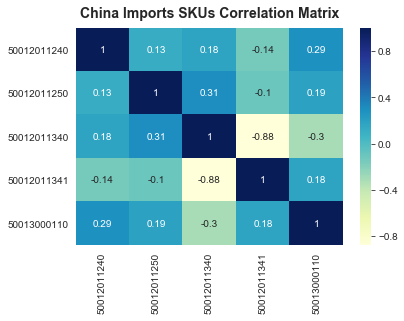

In [26]:
ax = sns.heatmap(SKU_pivot.corr(), cmap="YlGnBu", annot=True)
ax.set_title("China Imports SKUs Correlation Matrix", fontsize=14, fontweight="bold", y=1.02)
ax.set_ylabel("")
ax.set_xlabel("")

There are 3 relationships worth pursuing: 50012011240 vs 50013000110, 50012011250 vs 50012011340 and 50012011340 vs 50012011341. Two of these involve SKUs which began to be sold in 2016, so we should take that into account. Let's now visualise these relationships.

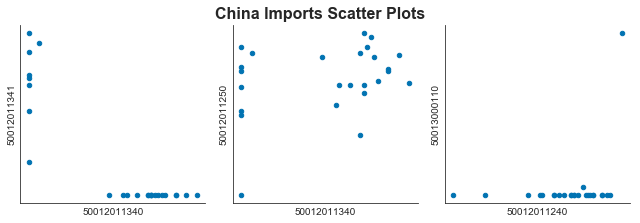

In [27]:
sns.set_palette("colorblind", 12)

fig, axes = plt.subplots(nrows=1, ncols=3)

ax1 = SKU_pivot.plot(50012011340, 50012011341, kind="scatter", ax=axes[0], figsize=(9,3))
ax2 = SKU_pivot.plot(50012011340, 50012011250, kind="scatter", ax=axes[1])
ax3 = SKU_pivot.plot(50012011240, 50013000110, kind="scatter", ax=axes[2])

ax1.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False, rotation=90)
ax2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False, rotation=90)
ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, labelleft=False, rotation=90)
fig.suptitle("China Imports Scatter Plots", fontsize=16, fontweight="bold", y=1.02)

sns.despine(top=True, right=True, left=False, bottom=False, ax=ax1)
sns.despine(top=True, right=True, left=False, bottom=False, ax=ax2)
sns.despine(top=True, right=True, left=False, bottom=False, ax=ax3)

plt.tight_layout()

For 50012011340 vs. 50012011341, the high -0.87 correlation coefficient is not a straightline at all, but rather a curve. There is a vertical column of values right at the beginning when 50012011340 = 0, and a horizontal row when 50012011341 = 0. The most likely reason for this is that the 2 products are interchangeable and are substituted for one another at any given time. So when the sales of one is zero, the other ones are booming.

For 50012011240 vs 50013000110, the plot suggests that there is no linear relationship between the sales of these 2 SKUs. The correlation coefficient is probably exaggerated due to the outlier in the top right corner.

Lastly, 50012011340 vs. 50012011250 has random points all over its graph. There is no significant relationship between these values.

### 4. TinyCo is thinking of running a one day promo on each week – which day of the week makes the most sense for each store?

To answer this question, we can strip off "day of week" from our dateindex, then proceed to group by it, aggregating over average.

In [28]:
Store_312["Day of week"] = Store_312.index.strftime("%a")

In [29]:
Store_312.head()

,SKU,Unit Sales,Dollar Sales,Month,Day of week
Date,,,,,
2014-08-04,50012011250,3,29.97,Aug,Mon
2014-08-05,50012011250,2,19.98,Aug,Tue
2014-08-06,50012011250,5,49.95,Aug,Wed
2014-08-07,50012011250,3,29.97,Aug,Thu
2014-08-08,50012011250,7,69.93,Aug,Fri


In [30]:
Store_312.pivot_table(values="Unit Sales", index="Day of week", aggfunc="mean").sort_values("Unit Sales", ascending=True)

,Unit Sales
Day of week,
Wed,3.527581
Mon,4.632653
Tue,4.657609
Thu,4.775244
Fri,8.580817
Sat,9.711645


**Wednesday** is the day that Store 312 should run a promotion on since it's the day with the least sales on average.

### 5. How do Unit Sales change over time?

The model we're going to build in this project is meant to project future sales of our SKUs so that we can then plan accordingly. To do this, we'll need to know what our data looks like. Before we build the model, we can explore the data for how Unit Sales of SKUs change over time, and how specific SKUs behave in certain time periods.

To begin with, let's plot a simple time series of total Unit Sales over the given time period.

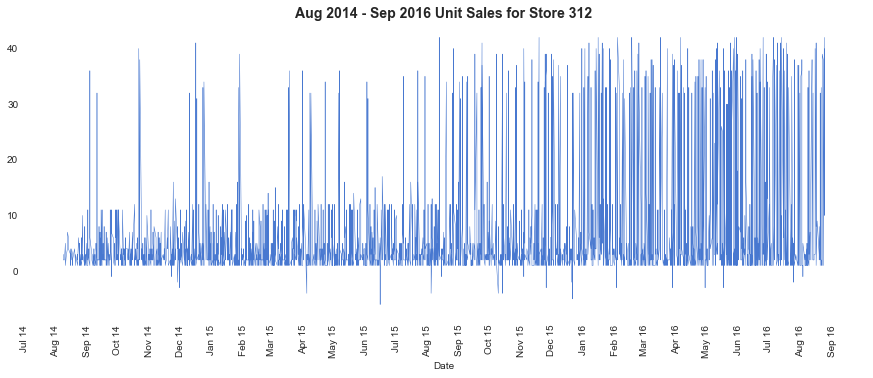

In [31]:
sns.set_style("white")
sns.set_palette("muted", 12)

plt.figure(figsize=(15,6))
ax = Store_312["Unit Sales"].plot(linewidth=0.5)
ax.set_title("Aug 2014 - Sep 2016 Unit Sales for Store 312", fontsize=14, fontweight="bold")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=90)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

The time series above is a plot for daily unit sales between Aug 2014 and Sep 2016. The spikes represent the sales on that particular day.

What's immediately noticeable are some spikes pointing downwards instead of upwards. These are the returns that we spoke of earlier. They are recorded as negative sales.

Another interesting observation is the peak spikes, as well as their frequency. To investigate those further, we can plot the time series as a dot plot to seperate the lower values from the peaking values.\

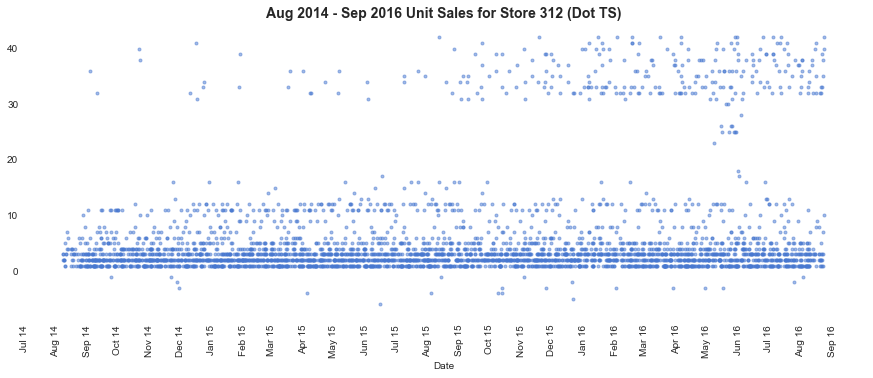

In [32]:
sns.set_style("white")
sns.set_palette("muted", 12)

plt.figure(figsize=(15,6))
ax = Store_312["Unit Sales"].plot(marker='.', alpha=0.5, linestyle='None')

ax.set_title("Aug 2014 - Sep 2016 Unit Sales for Store 312 (Dot TS)", fontsize=14, fontweight="bold")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=90)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
sns.set_palette("husl")
plt.show()

We can now see more clearly that there are 3 noticeable clusters in our graph.

 - The first one, which is the bottom one, consists of sales that are mostly below 5/batch.
 - The second, which is the one just above the first, consists of sales mostly between 5 and 15 in a batch.
 - The third one is the one which contains the peak sales. This one consists of sales above 25 a batch.
 
We can see some very interesting patterns from that graph. Cluster 1 mostly remains constant over the years. However, cluster 2 somewhat decreases in intensity around Oct 2015. The converse occurs for cluster 3 - it begins to increase in intensity during the same period going forward.

Let's look at subsets of these clusters and see if there's anything unique about them.

#### Cluster1

In [33]:
cluster1 = Store_312.loc[Store_312["Unit Sales"]<5]
cluster1.head()

,SKU,Unit Sales,Dollar Sales,Month,Day of week
Date,,,,,
2014-08-04,50012011250,3,29.97,Aug,Mon
2014-08-05,50012011250,2,19.98,Aug,Tue
2014-08-07,50012011250,3,29.97,Aug,Thu
2014-08-09,50012011250,4,39.96,Aug,Sat
2014-08-11,50012011250,4,39.96,Aug,Mon


In [34]:
print(Store_312.shape)
print(cluster1.shape)

(3565, 5)
(2618, 5)


In [35]:
print("These are the unique SKUs in cluster1:\n {}".format(cluster1.SKU.unique()))
print("The number of unique SKUs in cluster1 is {}".format(len(cluster1.SKU.unique())))
print("Store_312 has a set of unique SKUs with a length of {}".format(len(Store_312.SKU.unique())))

These are the unique SKUs in cluster1:
 [50012011250 50012011340 50012011341  8000451112  7312455530  7312455520
  8000520021 50012011240]
The number of unique SKUs in cluster1 is 8
Store_312 has a set of unique SKUs with a length of 9


It seams that this cluster has all the SKUs from Store_312 bar 1. Let's find out which one it is.

In [36]:
set(Store_312.SKU.unique()) - set(cluster1.SKU.unique())

{50013000110}

It seems as if SKU 50013000110 does not encounter purchases below 5 units.

Let's plot a doughnut to see what share our cluster1 SKUs have.

In [37]:
Pop1 = cluster1.pivot_table(values="Unit Sales", index="SKU", aggfunc="sum").sort_values("Unit Sales", ascending=False)

In [38]:
Pop1['Percentage'] = (Pop1['Unit Sales']/Pop1['Unit Sales'].sum())*100
Pop1.head(3)

,Unit Sales,Percentage
SKU,,
50012011250,1027,18.471223
50012011240,939,16.888489
7312455530,906,16.294964


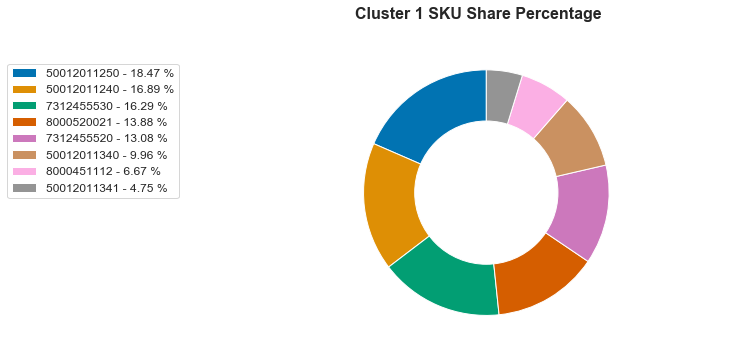

In [39]:
sns.set_palette("colorblind", 12)

fig, ax = plt.subplots(figsize=(9,5))

fig.suptitle("Cluster 1 SKU Share Percentage", fontsize=16, fontweight="bold", y=1.02)

patches, texts = plt.pie(Pop1.Percentage, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(Pop1.index, Pop1.Percentage)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, Pop1.Percentage),
                                          key=lambda x: x[2],
                                          reverse=True))

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')    
    
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)

plt.show()

Quite an interesting discovery we've got ourselves here. It seems that the SKU which tops sales overall from our earlier analysis, 8000451112, is not the one leading the pack here. In fact, it's second from last. Quite a fall from glory. In this subset, at least.

The 2 leading SKUs here are actually the ones from the vendor "China Imports". In this cluster, the sales of all SKUs from the vendor "China Imports" actually make up 50% of all sales.

As we've already noted, this cluster is the most intense of all the 3 clusters. This translates to sales from the vendor "China Imports" being among the most frequently purchased, albeit in small amounts. From a Supply Chain perspective, this means that the logistics of getting these stocks has to be made as efficient as possible. Making a presumption from the name "China Imports", if the products are indeed being imported from China, factors such as lead times have to be considered.

#### Cluster2

In [40]:
cluster2 = Store_312[(Store_312["Unit Sales"]>=5) & (Store_312["Unit Sales"]<15)]
cluster2.head()

,SKU,Unit Sales,Dollar Sales,Month,Day of week
Date,,,,,
2014-08-06,50012011250,5,49.95,Aug,Wed
2014-08-08,50012011250,7,69.93,Aug,Fri
2014-08-19,50012011250,6,59.94,Aug,Tue
2014-08-20,50012011250,5,49.95,Aug,Wed
2014-08-25,50012011250,5,49.95,Aug,Mon


In [41]:
print(Store_312.shape)
print(cluster2.shape)

(3565, 5)
(650, 5)


In [42]:
print("These are the unique SKUs in cluster2:\n {}".format(cluster2.SKU.unique()))
print("The number of unique SKUs in cluster2 is {}".format(len(cluster2.SKU.unique())))
print("Store_312 has a set of unique SKUs with a length of {}".format(len(Store_312.SKU.unique())))

These are the unique SKUs in cluster2:
 [50012011250 50012011340 50012011341  8000451112  7312455530  8000520021
 50012011240]
The number of unique SKUs in cluster2 is 7
Store_312 has a set of unique SKUs with a length of 9


It seams that this cluster has all the SKUs from Store_312 bar 2. Let's find out which one it is.

In [43]:
set(Store_312.SKU.unique()) - set(cluster2.SKU.unique())

{7312455520, 50013000110}

The same SKU missing from cluster1 is also missing from cluster2 - very interesting. In addition to this SKU, 7312455520 is also missing.

Let's also plot a doughnut here to see the share of sales by SKU in this cluster.

In [44]:
Pop2 = cluster2.pivot_table(values="Unit Sales", index="SKU", aggfunc="sum").sort_values("Unit Sales", ascending=False)

In [45]:
Pop2['Percentage'] = (Pop2['Unit Sales']/Pop2['Unit Sales'].sum())*100
Pop2.head(3)

,Unit Sales,Percentage
SKU,,
8000451112,1911,36.948956
8000520021,1813,35.054138
50012011250,947,18.310131


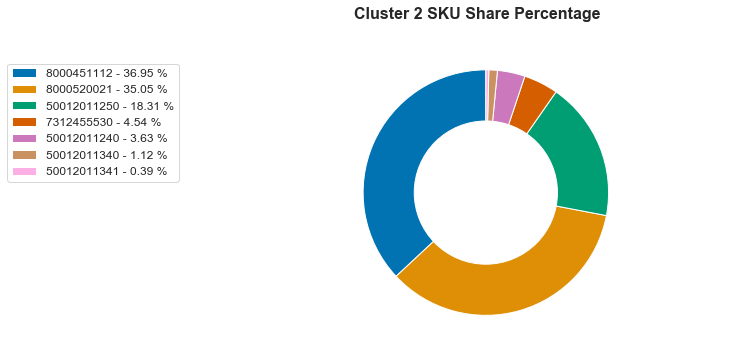

In [46]:
sns.set_palette("colorblind", 12)

fig, ax = plt.subplots(figsize=(9,5))

fig.suptitle("Cluster 2 SKU Share Percentage", fontsize=16, fontweight="bold", y=1.02)

patches, texts = plt.pie(Pop2.Percentage, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(Pop2.index, Pop2.Percentage)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, Pop2.Percentage),
                                          key=lambda x: x[2],
                                          reverse=True))

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')    
    
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)

plt.show()

It seems here that if a purchase has between 5 and 15 items, on average, 70% of that basket will contain SKUs from MA Excellent Products.

#### Cluster3

In [47]:
cluster3 = Store_312[Store_312["Unit Sales"]>15]
cluster3.head()

,SKU,Unit Sales,Dollar Sales,Month,Day of week
Date,,,,,
2016-05-02,50013000110,34,441.66,May,Mon
2016-05-03,50013000110,32,415.68,May,Tue
2016-05-04,50013000110,23,298.77,May,Wed
2016-05-05,50013000110,34,441.66,May,Thu
2016-05-06,50013000110,31,402.69,May,Fri


In [48]:
print(Store_312.shape)
print(cluster3.shape)

(3565, 5)
(293, 5)


In [49]:
print("These are the unique SKUs in cluster3:\n {}".format(cluster3.SKU.unique()))
print("The number of unique SKUs in cluster3 is {}".format(len(cluster3.SKU.unique())))
print("Store_312 has a set of unique SKUs with a length of {}".format(len(Store_312.SKU.unique())))

These are the unique SKUs in cluster3:
 [50013000110  8000451112  8000520021]
The number of unique SKUs in cluster3 is 3
Store_312 has a set of unique SKUs with a length of 9


Fascinating. Cluster3 only has 3 unique SKUs. The one missing from both clusters 1 & 2 - 50013000110 - as well as 2 others from MA Excellent Products - 8000451112 and 8000520021.

From earlier analysis, we can deduce from this insight that 8000451112 is the leading SKU in this cluster.

#### Percentage share of the clusters

In [50]:
labels = ["Cluster 1: Sales < 5", "Cluster 2: 5 <= Sales < 15", "Cluster 3: Sales > 15"]
clusters = [cluster1.shape[0], cluster2.shape[0], cluster3.shape[0]]
percentages = (np.array(clusters)/Store_312.shape[0]) * 100

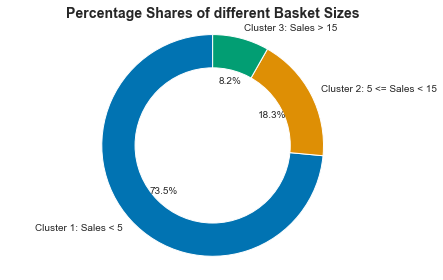

In [51]:
sns.set_palette("colorblind", 12)

fig3, ax3 = plt.subplots()
ax3.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax3.axis('equal')
ax3.set_title("Percentage Shares of different Basket Sizes", fontweight="bold", fontsize=14)

plt.tight_layout()
plt.show()

**Key take-aways from this exploration**:
 1. SKUs from the vendor "China Imports" are bought extremely frequently but in basket sizes less than 5.
 2. If a basket has a size of products between 5 and 15, they're most likely from MA Excellent Products.
 3. A basket size greater than 15 will almost certainly only contain these 3 SKUs: 50013000110, 8000451112 & 8000520021. Although their purchase frequency is nowhere near that of the other 2, it has been steadily increasing over the last 2 years.
 4. As the pie chart above shows, in a day,:
     - Purchases of items less than 5 make up 73.5% of the entire sales.
     - A basket size between 5 and 15 makes up 18.3% of the sales.
     - Sales > 15 make up 8.2% of the sales.

Basically, the bigger the basket size, the less frequent it is as a purchase.

_Now to go back to our time series_. We've seen what our data looks like when it is plotted daily, let's plot it in weekly buckets to notice if there's any pattern to weekly purchases.

### Weekly Seasonality

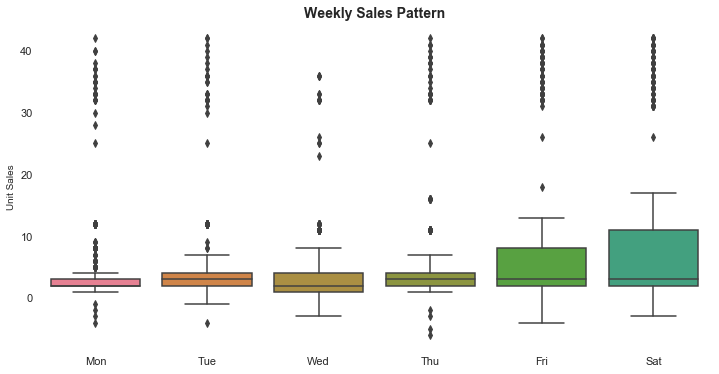

In [52]:
sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(12,6))

ax = sns.boxplot(data=Store_312, x='Day of week', y='Unit Sales')
ax.set_ylabel("Unit Sales")
ax.set_xlabel("", fontsize=12)
ax.set_title("Weekly Sales Pattern", fontweight="bold", fontsize=14)
ax.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

The diagram above is a time series of boxplots of unit sales. Each boxplot shows the spread of sales in a given day for our time period. Because each boxplot groups all the sales on that particular day, we can get an average understanding of how sales behave in a week.

From the graph above, we can see that sales are extremely slow on a Monday, with most of them  between 1 and 2. The median sales more or less remain the same throughout the week. However, we can see that the spread of sales is a litlle more far apart on a Wednesday, indicating a wider variety of sales. At the end of the week, Friday and Saturday, sales are extremely spread, indicating higher activity.

Apart from Wednesday, the outliers, which we should imagine to be the third cluster we analysed before, remain more or less the same.

### Yearly Seasonality

In [53]:
Store_312["Month_int"] = Store_312.index.strftime("%m")
Store_312.head()

,SKU,Unit Sales,Dollar Sales,Month,Day of week,Month_int
Date,,,,,,
2014-08-04,50012011250,3,29.97,Aug,Mon,08
2014-08-05,50012011250,2,19.98,Aug,Tue,08
2014-08-06,50012011250,5,49.95,Aug,Wed,08
2014-08-07,50012011250,3,29.97,Aug,Thu,08
2014-08-08,50012011250,7,69.93,Aug,Fri,08


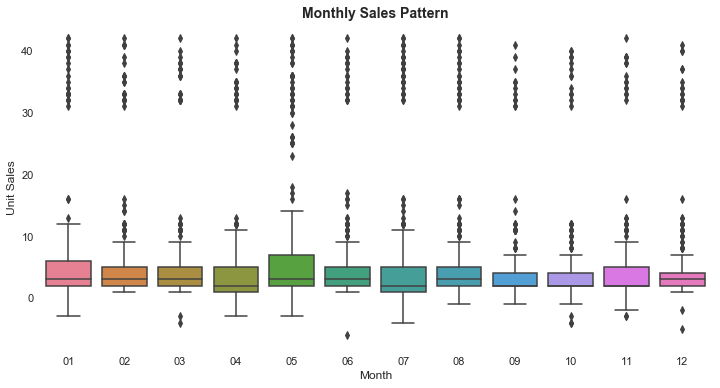

In [54]:
sns.set_style("white")
sns.set_palette("husl", 12)

plt.figure(figsize=(12,6))

ax = sns.boxplot(data=Store_312.sort_index(), x='Month_int', y='Unit Sales')
ax.set_ylabel("Unit Sales", fontsize=12)
ax.set_xlabel("Month", fontsize=12)
ax.set_title("Monthly Sales Pattern", fontweight="bold", fontsize=14)
ax.tick_params(labelsize=11)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

Interesting yearly seasonality here. There is a greater spread of unit sales in the middle of the year, than there is at the end of it. May in particular actually has more outlier values than any other month, indicating peak sales in that period.

### Identifying a Trend

Next up on our quest to see how unit sales behave over time, let's see if they form a trend over time.

Our data consists of multiple batches of sales on a single day. Therefore, if we were to plot a line chart on data that looks like that, it'll become very messy. To fix this, we can bin all sales on a particular day into a sum of those sales on that day. Let's do this on a copy of our data to preserve our dataset.

In [55]:
Store_312c = Store_312.resample("D").sum()

Our resampled dataset will now contain every single day from the time period provided, with sales aggregated by sum for that day. However, we can remember from our weekly seasonality boxplot that it didn't contain a Sunday. This is because TinyCo shops are closed on Sundays. The newly introduced Sundays will contain zeros, which we do not want. Let's remove them.

In [56]:
Store_312c = Store_312c.loc[Store_312c["Unit Sales"]>0]

The daily time series from before has a very high frequency variability, which is why it appears noisy. However, there is a pattern in that data and we can find it by decresing the frequency variability, i.e., by smoothing out seasonality. We've already established that there is weekly seasonality, so let's apply a 7-day rolling to our data.

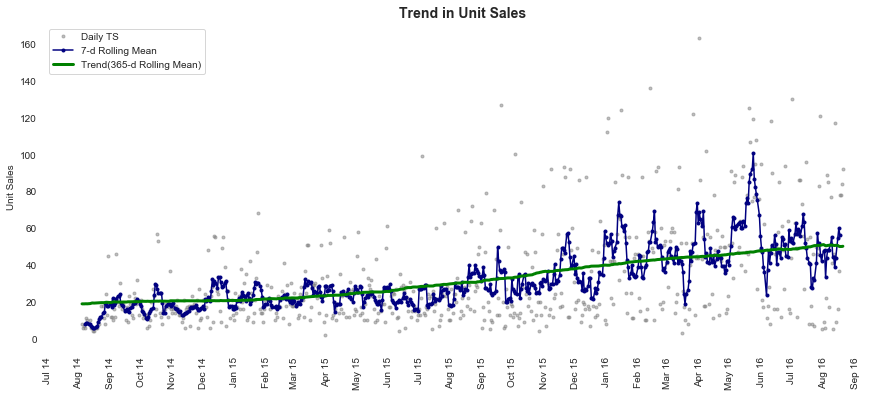

In [57]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(Store_312c["Unit Sales"], marker='.', alpha=0.5, linestyle='None', label="Daily TS", color="grey")
ax.plot(Store_312c["Unit Sales"].rolling(7, center=True).mean(), marker='.', label="7-d Rolling Mean", color="navy")
ax.plot(Store_312c["Unit Sales"].rolling(365, center=True, min_periods=120).mean(), label="Trend(365-d Rolling Mean)", color="green", linewidth=3)
ax.set_ylabel("Unit Sales")
ax.set_title("Trend in Unit Sales", fontsize=14, fontweight="bold")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.legend(loc="upper left")

plt.xticks(rotation=90)

sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
plt.show()

The grey dots are the daily resampled time series. They contain both weekly and annual seasonality, hence why they are all over the place.

The navy blue line is a 7 day rolling mean. It averages out the weekly variation, but maintains the seasonality found through the year. Although this is an improvement on the dots, it still doesn't give a clear direction of where the trend is going.

The green line is a 365 day rolling mean. It seeks out the seasonality in the year and averages that out as well, leaving us with a smooth line, which we can easily deduce direction of sales from.

As we can see, the trend shows that the sales are steadily rising.

### 6. How do these SKUs behave differently in the other stores?

This question can only be answered once the other 4 stores have gone through the processes in Part 1, as well as all the other ones in this notebook. For demonstrative processes, we'll end here, however.

_You are free to go through the other stores on your own and add on my work and/or critic it if you'd like to._

Please leave a comment in the comments section if you've any question or contributions.

**End of Part 2**

The third and final part of the project continues in the next notebook.

<br>
<br>
<br>
<br>
***
<footer>_Author: Simbarashe Chikaura -- Data Analyst_</footer>
***